# Dataset Description

The dataset was taken from the Kaggle: https://archive.ics.uci.edu/ml/datasets/SPECT+Heart.  

**Short description of the dataset**  
The dataset describes diagnosing of cardiac Single Proton Emission Computed Tomography (SPECT) images. Each of the patients is classified into two categories: normal and abnormal (0 and 1).  
The database of 267 SPECT image sets (patients) was processed to extract features that summarize the original SPECT images. As a result, 44 continuous feature pattern was created for each patient. The pattern was further processed to obtain 22 binary feature patterns. The CLIP3 algorithm was used to generate classification rules from these patterns. The CLIP3 algorithm generated rules that were 84.0% accurate (as compared with cardilogists' diagnoses).

SPECT is a good data set for testing ML algorithms; it has 267 instances that are descibed by 23 binary attributes.

Attribute Information:

1) Diagnosis (1 = positive, 0 = negative)  
3) 22 features, each of which describes a partial diagnosis (1 - abnormal, 0 - normal).


**Initial data shape:**  
267, 23

In [252]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import operator

In [253]:
df = pd.concat([pd.read_csv('SPECT.test.csv', header = None), pd.read_csv('SPECT.train.csv', header = None)], ignore_index=True)
# Reading the dataset
columns = ['diagnosis']
columns.extend(['feature' + str(i) for i in range(1, len(df.columns))])
df.columns = columns
df = df.sample(frac=1).reset_index(drop=True)
print('Shape of the dataset: ', df.shape)
df.head()

Shape of the dataset:  (267, 23)


,diagnosis,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22
0,1,1,1,1,1,1,1,0,0,1,...,1,0,1,1,0,0,1,1,0,1
1,0,0,0,1,1,0,0,1,0,0,...,1,1,0,0,0,0,0,0,1,1
2,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1


Analysis of the correlated features.

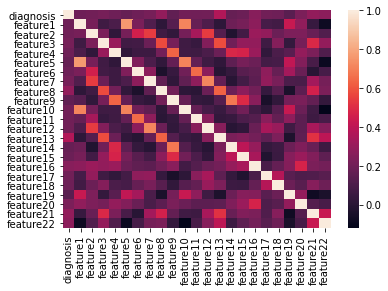

In [254]:
# The heatmap of features
# calculate the correlation matrix
corr = df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

There are some features that are highly positively correlated, but as the dataset is not extremely big and is famous for not high accuracy and precision results even while using random forest, it is decided not to exclude those.

# Pre-processing
## Omition of the null values

In [255]:
null_ = df.isnull().sum()
print(null_[null_ > 0])

Series([], dtype: int64)


# Metrics
Metrics used and their ideal values:  
- accuracy \\( =\frac{TP+TN}{TP+TN+FP+FN}\\), ideal - 100%  
- precision \\( = \frac{TP}{TP+FP}\\), ideal - 100%  
- recall (TPR) \\( = \frac{TP}{TP+FN}\\), ideal - 100%  
- negative predictive value \\( = \frac{TN}{TN+FN}\\), ideal - 100%  
- false positive rate \\( = \frac{FP}{FP+TN}\\), ideal - 0%  
- false negative rate \\( = \frac{FN}{FN+TP}\\), ideal - 0%  
- false discovery rate \\( = \frac{FP}{FP+TP}\\), ideal - 0%  
- f1 score \\( = \frac{2\cdot TP}{2 \cdot TP + FP + FN} = \frac{2\cdot recall\cdot precision}{recall + precision}\\), ideal - 1

# Algorithms
## FCA classification

Firstly, the hyperparameter's value is defined, which is a number of features multiplied by threshold - the parameter tha can be tuned.
The object is classified positively if the cardinality of its intersection with marked positively example from the train sample exceeds the hyperparameter's value.

In [256]:
class BasicFCA_classifier(BaseEstimator, ClassifierMixin):
    # basic constructor containing threshold param
    def __init__(self, thr=0.72):
        self.thr = thr
    # fitting X - np.array of features'values
    # and y - target feature's values
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        self.X_p = X[y == 1]
        self.X_n = X[y == 0]
        return self

    def predict(self, X):
        y_pred = []
        parameter = self.X_.shape[1] * self.thr
        for x in X:
            pos = {i for i in range(len(self.X_p)) \
                   if np.sum(x == self.X_p[i]) > int(parameter)}
            neg = {i for i in range(len(self.X_n)) \
                   if np.sum(x == self.X_n[i]) > int(parameter)}
            pos = len(pos) / len(self.X_p)
            neg = len(neg) / len(self.X_n)
            if (pos > neg):
                # pos classification
                y_pred.append(1)
                
            elif (pos == neg):
                #contradictory
                y_pred.append(3)
            else:
                # neg classification
                y_pred.append(0)

        y_pred = np.array(y_pred)
        
        return y_pred
    

df = df.astype(int)
X = df.iloc[:,1:].values
y = df['diagnosis'].values
fca_classifier = BasicFCA_classifier()
print('Accuracy:', (np.mean(cross_val_score(fca_classifier, X, y, cv=5))*100).round(2), '%')
print('Recall:', (np.mean(cross_val_score(fca_classifier, X, y, cv=5, scoring='recall'))*100).round(2), '%')
print('Precision:', (np.mean(cross_val_score(fca_classifier, X, y, cv=5, scoring='precision'))*100).round(2), '%')
print('F1:', np.mean(cross_val_score(fca_classifier, X, y, cv=5, scoring='f1')).round(2))

Accuracy: 57.69 %
Recall: 48.58 %
Precision: 96.44 %
F1: 0.64


In [257]:
grid_search = GridSearchCV(BasicFCA_classifier(), {'thr': np.linspace(0.5, 1, 10)})
grid_search.fit(X, y)
thr = grid_search.best_estimator_

In [264]:
print('Best threshold:', thr)

Best threshold: BasicFCA_classifier(thr=0.7222222222222222)


## Naive Bayes classifier

In [259]:
naive_classifier =GaussianNB()
print('Accuracy:', (np.mean(cross_val_score(naive_classifier, X, y, cv=5))*100).round(2), '%')
print('Recall:', (np.mean(cross_val_score(naive_classifier, X, y, cv=5, scoring='recall'))*100).round(2), '%')
print('Precision:', (np.mean(cross_val_score(naive_classifier, X, y, cv=5, scoring='precision'))*100).round(2), '%')
print('F1:', np.mean(cross_val_score(naive_classifier, X, y, cv=5, scoring='f1')).round(2))

Accuracy: 57.32 %
Recall: 47.65 %
Precision: 97.63 %
F1: 0.64


## Fuzzy classifier
Algorithm:  
1. The samples fitting  
    - K-nearest neighbours are found \\(\Vert A \Vert = \sqrt{\sum_{i=1}^{n_1}\sum_{j=1}^{n_2} a_{ij}}\\)  
    - memberships in each class are assigned according to the equation:
    
$$u_{ij} = \begin{cases}
0.51+(n_j/K)\cdot0.49, i = j \\
(n_j/K)\cdot 0.49,   i \neq j
\end{cases},$$ where \\(n_j\\) - is the number of the neighbours found which belong to \\(j\\) class.  
2. Predicting of the X test values  
\\(u_i(x)\\) - assigned membership of the vector x:
$$u_i(x) = \frac {u_{ij}\sum_{i=1}^{K} (1/\Vert x-x_j \Vert^{2/(m-1)})} {\sum_{i=1}^{K} (1/\Vert x-x_j \Vert^{2/(m-1)})},$$ where \\(u_{ij}\\) - the membership in the \\(i\\) -th class of the \\(j\\) vector of the labeled sample set. Max \\(u_i\\) - the resulting vote of the class.

In [260]:
# Fuzzy Estimator

class Fuzzy(BaseEstimator, ClassifierMixin):
    
    def __init__(self, k=5):
        self.k = k
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        # Number of features
        self.x_d = np.shape(self.X)[1] 
        self.n = len(y)
        # +/- classes
        classes = np.unique(y)
        self.classes = set(classes)
        
        self.df = pd.DataFrame(self.X)
        self.df['class'] = self.y
        
        self.relations = self.fuzzy_relation()
        self.df['relation'] = self.relations
        
        self.fitted_ = True
        return self
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict called before fit')
        else:
            # Hyperparameter
            m = 2 
            y_pred = []
            for x in X:
                # k nearest neighbours found 
                neighbours = self._k_nearest(pd.DataFrame.copy(self.df), x)
                # The votes - 'for' +/- classes
                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        # distance between the object and neares kneighbour n
                        dist = np.linalg.norm(x - neighbours.iloc[n,0:self.x_d]) 
                        if dist == 0:
                            dist = 1
                        # den = denominator of 𝑢_𝑖(𝑥)
                        den += 1 / (dist ** (2. / (m-1.0))) 
                    
                    neighbours_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbours.iloc[n,0:self.x_d])
                        if dist == 0:
                            dist = 1
                        #num = numerator of 𝑢_𝑖(𝑥)
                        num = (neighbours.iloc[n].relation[c]) / (dist ** (2 / (m-1)))
                        vote = num/den
                        neighbours_votes.append(vote)
                    votes[c] = np.sum(neighbours_votes)
                # Max Vote    
                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append(pred)
                
            return y_pred
    
    
    def _k_nearest(self, df, x):
        X = df.iloc[:,0:self.x_d].values
        # Distance for all objects
        df['d_i'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        df.sort_values(by='d_i', ascending=True, inplace=True)
        # K nearest objects
        neighbours = df.iloc[0:self.k]
        
        return neighbours

                
    def _classes_number(self, neighbours):
        
        groups = neighbours.groupby('class')['class'].count()
        counts = {groups.index[i]: groups.iloc[i] for i in range (groups.size)}
        return counts
        
        
    def fuzzy_relation(self):
        relations = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            neighbours = self._k_nearest(pd.DataFrame.copy(self.df), x)
            counts = self._classes_number(neighbours)
            relation = dict()
            for c in self.classes:
                try:
                    uci = 0.49 * (counts[c] / self.k) # agg function
                    if c == y:
                        uci += 0.51
                    relation[c] = uci
                except:
                    relation[c] = 0
                    
            relations.append(relation)
        return relations
    
    def __del__(self):
        pass

In [261]:
fuzzy_classifier = Fuzzy()
print('Accuracy:', (np.mean(cross_val_score(fuzzy_classifier, X, y, cv=5))*100).round(2), '%')
print('Recall:', (np.mean(cross_val_score(fuzzy_classifier, X, y, cv=5, scoring='recall'))*100).round(2), '%')
print('Precision:', (np.mean(cross_val_score(fuzzy_classifier, X, y, cv=5, scoring='precision'))*100).round(2), '%')
print('F1:', np.mean(cross_val_score(fuzzy_classifier, X, y, cv=5, scoring='f1')).round(2))

Accuracy: 80.52 %
Recall: 87.24 %
Precision: 88.34 %
F1: 0.88


## Logistic regression

In [262]:
log_classifier = LogisticRegression()
print('Accuracy:', (np.mean(cross_val_score(log_classifier, X, y, cv=5))*100).round(2), '%')
print('Recall:', (np.mean(cross_val_score(log_classifier, X, y, cv=5, scoring='recall'))*100).round(2), '%')
print('Precision:', (np.mean(cross_val_score(log_classifier, X, y, cv=5, scoring='precision'))*100).round(2), '%')
print('F1:', np.mean(cross_val_score(log_classifier, X, y, cv=5, scoring='f1')).round(2))

Accuracy: 83.12 %
Recall: 92.91 %
Precision: 86.81 %
F1: 0.9


## Random forest

In [263]:
forest_classifier = RandomForestClassifier()
print('Accuracy:', (np.mean(cross_val_score(forest_classifier, X, y, cv=5))*100).round(2), '%')
print('Recall:', (np.mean(cross_val_score(forest_classifier, X, y, cv=5, scoring='recall'))*100).round(2), '%')
print('Precision:', (np.mean(cross_val_score(forest_classifier, X, y, cv=5, scoring='precision'))*100).round(2), '%')
print('F1:', np.mean(cross_val_score(forest_classifier, X, y, cv=5, scoring='f1')).round(2))

Accuracy: 82.76 %
Recall: 91.51 %
Precision: 86.99 %
F1: 0.89


# Overall results

(Can be changed a little bit due to a not fixed random state)

Classifier | Accuracy (%) | Precision (%) | Recall (%)
--- | --- | --- | ---
FCA | 58.06 | 97.02 | 49.07
Naive Bayes | 57.68 | 97.34 | 48.12
Fuzzy | 79.41 | 89.36 | 84.43
Log regression | 85.01 | 88.06 | 93.84
Random forest | 81.67 | 86.0 | 90.55